# Coastal Impacts from freshwater discharge - Amazon or Arctic 

Intro to use case, motivation, connections to cloud migration, learning objectives...

Cloud-based capabilities used:
- search by shp ( *?? is this service in the cloud Ops at this point?*)

Cloud-based dataset(s) used:
- MODIS SST L2

Steps in this demo:
1. search CMR for collection and granule IDs
2. download a file and preview the data
3. search a collection by user-provided shapefile (ESRI shp)
4. preview subset (<-- *this still needs to be written*)
4. download all data based on shp search criteria (<-- *this still needs to be written*)

In [1]:
from urllib import request, parse
from http.cookiejar import CookieJar
import getpass
import netrc
import os
import requests
import json
import pprint
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rasterio
from rasterio.plot import show
import numpy as np
import os
import time
from netCDF4 import Dataset
from owslib.wms import WebMapService
%matplotlib inline

## Local directory setup 

Specify a local directory where the following Harmony outputs will be saved:

In [2]:
# ---- Change this to save to a directory where you have write permissions

#local_dir = '/dirpath/username/foldername/'
local_dir = '/Users/catoaida/inSync Share/PODAAC/Trainings/AGU_FM_workshop_2020/Notebooks/Outputs/'

## Earthdata Login Authentication

An Earthdata Login account is required to access data from NASA EOSDIS. At this point in time (as we are still trnasitioning to a cloud environement), in order to access data from the Harmony API or cloud-based data, you need special persmissions. For the workshop today, you have been already added to the list and the earthdata login you provided prior to the workshop has been granted this access. 

We need some boilerplate up front to log in to Earthdata Login.  The function below will allow Python scripts to log into any Earthdata Login application programmatically.  To avoid being prompted for
credentials every time you run and also allow clients such as curl to log in, you can add the following
to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc` 


In [3]:
from netrc import netrc
from platform import system
from getpass import getpass
from urllib import request
from http.cookiejar import CookieJar
from os.path import join, expanduser

TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>PODAAC CMR Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_cmr_token_auth(endpoint: str='cmr.earthdata.nasa.gov'):
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    return requests.post(
        url="https://%s/legacy-services/rest/tokens" % endpoint,
        data=TOKEN_DATA % (input("Username: "), getpass("Password: "), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    ).json()['token']['id']


def setup_earthdata_login_auth(endpoint: str='urs.earthdata.nasa.gov'):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)


# Get your authentication token for searching restricted records in the CMR:
_token = setup_cmr_token_auth(endpoint="cmr.earthdata.nasa.gov")

# Start authenticated session with URS to allow restricted data downloads:
setup_earthdata_login_auth(endpoint="urs.earthdata.nasa.gov")

Username: oceancat18
Password: ········


## A note on CMR
CMR, the Common Metadata Repository, houses metadata for the 12 different DAACs. These come in the following forms:

* Collections
* Granules
* Variables
* Services
* Visualizations
* Tools

## 1. Identify a data collection of interest

A CMR collection ID is needed to request services through Harmony. The collection ID can be determined using the [CMR API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html). 

Level 2 data shortnames: `MODIS_A-JPL-L2P-v2019.0` 

One way to find the **shortname of a collection** is to go to https://search.earthdata.nasa.gov/search and type *POCLOUD* in the search box (which is the PO.DAAC data provider for cloud-based Pathfinder datasets in a restricted operational cloud environment). Click on the (i) next to the data collection of interest; the shortname is the `subheader` name below the main full data collection name.

------------ The following way to search CMR is consistent with other PO.DAAC developed notebooks, e.g. Tutorial 7 (Jack McNelis) ------------

Data from shortname dataset **MODIS_A-JPL-L2P-v2019.0** can be obtained from/in the cloud.

### Search by dataset shortname and provider

To search Earthdata for the specific **collections** desired from this notebook, we can use the following code with key words that describe our dataset (also knows as a *collection*). First we will search for the MODIS SST dataset. This snippet of Python code uses the requests module to get collection metadata from the CMR:

In [4]:
modis_coll = requests.get(
    url="https://cmr.earthdata.nasa.gov/search/collections.umm_json",    # CMR API url
    params={'ShortName': "MODIS_A-JPL-L2P-v2019.0",       # dataset collection shortname
            'provider': "POCLOUD",       # data provider
            'token': _token},
).json()

modis_coll['items'][0]['meta']   # print collection metadata

{'revision-id': 2,
 'deleted': False,
 'format': 'application/vnd.nasa.cmr.umm+json',
 'provider-id': 'POCLOUD',
 'user-id': 'cia001',
 'has-formats': True,
 'associations': {'services': ['S1962070864-POCLOUD']},
 'has-spatial-subsetting': False,
 'native-id': 'GHRSST+Level+2P+Global+Sea+Surface+Skin+Temperature+from+the+Moderate+Resolution+Imaging+Spectroradiometer+(MODIS)+on+the+NASA+Aqua+satellite+(GDS2)',
 'has-transforms': False,
 'has-variables': False,
 'concept-id': 'C1940473819-POCLOUD',
 'revision-date': '2020-09-15T19:49:35.109Z',
 'granule-count': 0,
 'has-temporal-subsetting': False,
 'concept-type': 'collection'}

Based on the metadata retrieved above, we now know the collection ID is `C1940473819-POCLOUD`

To **retrieve the *granule (file)* metadata** from the CMR:

In [5]:
modis_gran = requests.get(
    url="https://cmr.earthdata.nasa.gov/search/granules.umm_json", 
    params={'ShortName': "MODIS_A-JPL-L2P-v2019.0", 
            'provider': "POCLOUD",
            'token': _token, },
).json()

modis_gran['items'][0]['meta']

{'concept-type': 'granule',
 'concept-id': 'G1966131201-POCLOUD',
 'revision-id': 1,
 'native-id': '20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0',
 'provider-id': 'POCLOUD',
 'format': 'application/vnd.nasa.cmr.umm+json',
 'revision-date': '2020-11-12T11:09:16.542Z'}

So in this case, the metadata tells us that the the granule ID is `G1966131201-POCLOUD`, among other information.

---------- 
### Give it a try!
Instead of MODIS, try searching for the TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2 collection, and get a glimpse into its metadata.

----------

## 2. Download a granule & preview data

### Preview the data - get a quick feel for what the data looks like
Here is how to list the urls needed to access the data:

In [6]:
modis_gran['items'][0]['umm']['RelatedUrls']

[{'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/MODIS_A-JPL-L2P-v2019.0/20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc.md5',
  'Description': 'Download 20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc.md5',
  'Type': 'EXTENDED METADATA'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc',
  'Description': 'Download 20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc',
  'Type': 'GET DATA'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/MODIS_A-JPL-L2P-v2019.0/20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.cmr.json',
  'Description': 'Download 20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.cmr.json',
  'Type': 'EXTENDED METADATA'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/s3credentials',
  'Description': 'api endpoint to retri

You want the 'Type': 'GET DATA' url.

In [7]:
modis_url = modis_gran['items'][0]['umm']['RelatedUrls'][1]['URL']
modis_url

'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20020704000015-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc'

Download the file and open it with xarray in memory. This will pull cloud-stored data onto local space. *Note there is no charge for the user in doing so.* 

In [8]:
r = requests.get(modis_url)
with open('tutorial2_data_MODIS.nc', 'wb') as f:
    f.write(r.content)

In [9]:
# this is for debugging only, do not keep in final; 200=success, 401=unauthorized
r.status_code

200

In [10]:
!ncdump -h tutorial2_data_MODIS.nc

netcdf tutorial2_data_MODIS {
dimensions:
	nj = 2030 ;
	ni = 1354 ;
	time = 1 ;
variables:
	float lat(nj, ni) ;
		string lat:long_name = "latitude" ;
		string lat:standard_name = "latitude" ;
		string lat:units = "degrees_north" ;
		lat:_FillValue = -999.f ;
		lat:valid_min = -90.f ;
		lat:valid_max = 90.f ;
		string lat:comment = "geographical coordinates, WGS84 projection" ;
		string lat:coverage_content_type = "coordinate" ;
	float lon(nj, ni) ;
		string lon:long_name = "longitude" ;
		string lon:standard_name = "longitude" ;
		string lon:units = "degrees_east" ;
		lon:_FillValue = -999.f ;
		lon:valid_min = -180.f ;
		lon:valid_max = 180.f ;
		string lon:comment = "geographical coordinates, WGS84 projection" ;
		string lon:coverage_content_type = "coordinate" ;
	int time(time) ;
		string time:long_name = "reference time of sst file" ;
		string time:standard_name = "time" ;
		string time:units = "seconds since 1981-01-01 00:00:00" ;
		string time:comment = "time of first sensor obse

In [12]:
import xarray as xa
ds_MODIS = xa.open_dataset('tutorial2_data_MODIS.nc')
ds_MODIS

<xarray.Dataset>
Dimensions:                      (ni: 1354, nj: 2030, time: 1)
Coordinates:
    lat                          (nj, ni) float32 ...
    lon                          (nj, ni) float32 ...
  * time                         (time) datetime64[ns] 2002-07-04T00:00:10
Dimensions without coordinates: ni, nj
Data variables:
    sea_surface_temperature      (time, nj, ni) float32 ...
    sst_dtime                    (time, nj, ni) timedelta64[ns] ...
    quality_level                (time, nj, ni) float32 ...
    sses_bias                    (time, nj, ni) float32 ...
    sses_standard_deviation      (time, nj, ni) float32 ...
    l2p_flags                    (time, nj, ni) int16 ...
    sea_surface_temperature_4um  (time, nj, ni) float32 ...
    quality_level_4um            (time, nj, ni) float32 ...
    sses_bias_4um                (time, nj, ni) float32 ...
    sses_standard_deviation_4um  (time, nj, ni) float32 ...
    wind_speed                   (time, nj, ni) float32 ...
    dt_analysis                  (time, nj, ni) float32 ...
Attributes:
    Conventions:                CF-1.7, ACDD-1.3
    title:                      MODIS Aqua L2P SST
    summary:                    Sea surface temperature retrievals produced a...
    references:                 GHRSST Data Processing Specification v2r5
    institution:                NASA/JPL/OBPG/RSMAS
    history:                    MODIS L2P created at JPL PO.DAAC
    comment:                    L2P Core without DT analysis or other ancilla...
    license:                    GHRSST and PO.DAAC protocol allow data use as...
    id:                         MODIS_A-JPL-L2P-v2019.0
    naming_authority:           org.ghrsst
    product_version:            2019.0
    uuid:                       f6e1f61d-c4a4-4c17-8354-0c15e12d688b
    gds_version_id:             2.0
    netcdf_version_id:          4.1
    date_created:               20200727T162441Z
    file_quality_level:         3
    spatial_resolution:         1km
    start_time:                 20020704T000010Z
    time_coverage_start:        20020704T000010Z
    stop_time:                  20020704T000458Z
    time_coverage_end:          20020704T000458Z
    northernmost_latitude:      47.4713
    southernmost_latitude:      26.6848
    easternmost_longitude:      46.3095
    westernmost_longitude:      15.0158
    source:                     MODIS sea surface temperature observations fo...
    platform:                   Aqua
    sensor:                     MODIS
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    acknowledgment:             The MODIS L2P sea surface temperature data ar...
    creator_name:               Ed Armstrong, JPL PO.DAAC
    creator_email:              edward.m.armstrong@jpl.nasa.gov
    creator_url:                http://podaac.jpl.nasa.gov
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             The GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L2P
    cdm_data_type:              swath
    startDirection:             Descending
    endDirection:               Descending
    day_night_flag:             Night

Let's do a **quick plot**:

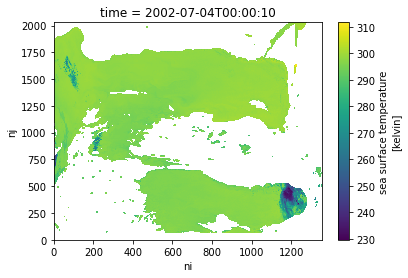

In [13]:
from pandas.plotting import register_matplotlib_converters

ds_MODIS.sea_surface_temperature.plot()

We can see the time this file represents, and the variable, but it's hard to tell where on the map we are. Let's try it another way:

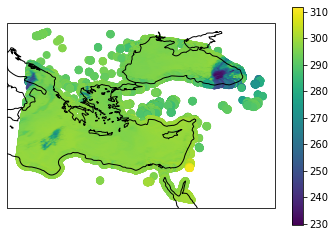

In [14]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

plt.scatter(ds_MODIS.lon, ds_MODIS.lat, lw=2, c=ds_MODIS.sea_surface_temperature)
plt.colorbar()
#plt.clim(-0.3, 0.3)

plt.show()

We can double check the data by plotting it in a separate application, such as Panoply. The data matches, in this case we're looking at MODIS SST over the Meditterranean sea, at the first time stamp in the collection.

<img align="left"
     src="MODIS_SST_demo2.png">

## 3. Select data with shp file using the Harmony API

Now that we know the collection ID we are interested in, we can pass that into the Harmony cloud-based services to perform several transformation on the data. Here we show how to **subset by geographic shapefile**. We will use the previously found collection ID for the MODIS SST dataset collection `MODIS_A-JPL-L2P-v2019.0`.

### Access data selected by geographic shapefile
We will request data overlapping South America by uploading a shapefile with that boundary.

This requires the use of a multipart/form-data POST request. Supported shapefile formats include ESRI, GeoJSON, and KML. The associated mime-types are as follows:

| Shapefile Format | mime-type |
|:-----------------|----------:|
| ESRI | application/shapefile+zip |
| GeoJSON | application/geo+json |
| KML | application/vnd.google-earth.kml+xml |


ESRI shapefiles must be uploaded as a single .zip file.

*DEV note: This next section could use some updating, try to make it a bit cleaner, parameterize the inputs that can be changes, e.g. shp file or collection ID*

First, let's define the collection of interest, using a variable `harmony_collection_id`:

In [15]:
# harmony_collection_id = 'C1940473819-POCLOUD'

### Example with ESRI .shp file:

In [16]:
import requests
import json
import pprint

# the URL of the CMR searvice
url = 'https://cmr.earthdata.nasa.gov/search/granules.json'

#The shapefile we want to use in our search
shp_file = open('shapefiles/gulf_shapefile.zip', 'rb')

#need to declare the file and the type we are uploading
files = {'shapefile':('gulf_shapefile.zip',shp_file, 'application/shapefile+zip')}

#used to define parameters such as the concept-id and things like temporal searches
parameters = {'echo_collection_id':'C1940473819-POCLOUD'}

response = requests.post(url, files=files, params=parameters)
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(response.json())

{ 'feed': { 'entry': [],
            'id': 'https://cmr.earthdata.nasa.gov:443/search/granules.json',
            'title': 'ECHO granule metadata',
            'updated': '2020-11-17T22:47:34.755Z'}}


DEV: Not clear if this actually works? can we only use shp seach on PODAAC provider data, or also POCLOUD?

## 4. Preview the selected data

In [ ]:
# code goes here

### --> Can/should we also add temporal selection?

## 5. Download after selection with shp
Loop to Download the MODIS files based on our search criteria (those that intersect the region of interested (defined by our shapefile here).

In [ ]:
# code goes here




## ------ END Tutorial 2 ------